In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 256,256 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size


Using TensorFlow backend.


In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
from keras.applications import vgg16 
from keras.models import Model 
import keras 


vgg = vgg16.VGG16(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 

 
vgg_model.trainable = True 


In [6]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001CDED913A88>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x000001CDF78DBAC8>,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0x000001CDED90FC48>,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0x000001CDE631A1C8>,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0x000001CDE631AE88>,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0x000001CDE6323E88>,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0x000001CDE6327DC8>,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0x000001CDE6327248>,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0x000001CDE6331B48>,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0x000001CDE633A4C8>,block3_conv3,True


In [7]:
from os import listdir
from os.path import isfile,isdir, join
import numpy

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from keras.optimizers import RMSprop 
from sklearn.model_selection import train_test_split

In [8]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer 
from keras.models import Sequential 
from keras import optimizers  
import tensorflow as tf

# build model architecture 
model = Sequential() 
model.add(vgg_model) 
model.add(Dense(64, activation='relu', input_dim=input_shape)) 
model.add(Dropout(0.25)) 
model.add(Dense(num_class, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [10]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 32768)             14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2097216   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 16,812,034
Trainable params: 16,812,034
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
history = model.fit_generator(train, steps_per_epoch=64, 
                              epochs=15,  
                              validation_data=val,   
                              validation_steps=50,  
                              verbose=1)

Epoch 1/15
64/64 [==============================] - 43s 665ms/step - loss: 0.6657 - accuracy: 0.6333 - f1_m: 0.6530 - precision_m: 0.5706 - recall_m: 0.7695 - val_loss: 0.6020 - val_accuracy: 0.7825 - val_f1_m: 0.7665 - val_precision_m: 0.6973 - val_recall_m: 0.8531
Epoch 2/15
64/64 [==============================] - 35s 542ms/step - loss: 0.6023 - accuracy: 0.7720 - f1_m: 0.7399 - precision_m: 0.7266 - recall_m: 0.7568 - val_loss: 0.5739 - val_accuracy: 0.7856 - val_f1_m: 0.7825 - val_precision_m: 0.7917 - val_recall_m: 0.7744
Epoch 3/15
64/64 [==============================] - 37s 576ms/step - loss: 0.5461 - accuracy: 0.7925 - f1_m: 0.7811 - precision_m: 0.7864 - recall_m: 0.7773 - val_loss: 0.5154 - val_accuracy: 0.7917 - val_f1_m: 0.7897 - val_precision_m: 0.8052 - val_recall_m: 0.7755
Epoch 4/15
64/64 [==============================] - 35s 551ms/step - loss: 0.5153 - accuracy: 0.8018 - f1_m: 0.7976 - precision_m: 0.8076 - recall_m: 0.7891 - val_loss: 0.4296 - val_accuracy: 0.8100 

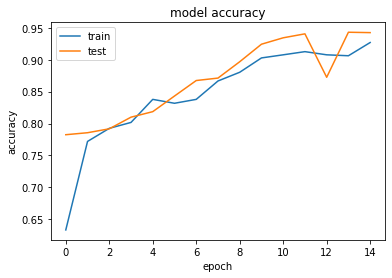

In [12]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

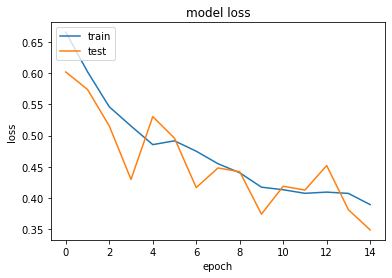

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

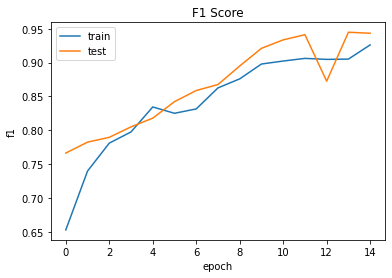

In [14]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

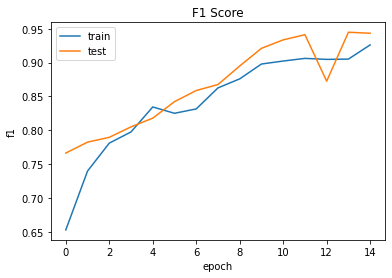

In [15]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

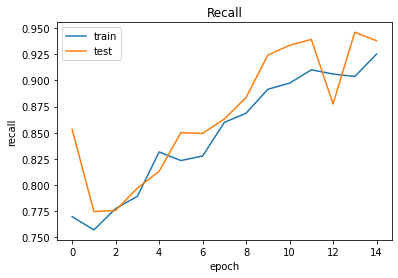

In [16]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

142/142 [==============================] - 22s 154ms/step
El modelo predice el  94.50936913490295 % de los datos
